In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
from   sklearn.metrics.pairwise import cosine_similarity

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## colaborative filtering with Pearson Correlation

In [58]:
class PreProcess:
    def read_data(self,file_path):
        return pd.read_csv(file_path)
    def null_check(self,df):
        print(df.isnull().sum())
    def remove_null_data(self,df):
        return df.dropna()
    def peek_data_head(self,df,number):
        return df.head(number)
    def peek_data_last(self,df,number):
        return df.tail(number)
    def join_datasets(self,df1,df2,foreign_key,where='left'):
        return df1.merge(df2,how=where,on=foreign_key)
    def user_name_edit(self,df):
        df['userId'] = df['userId'].apply(lambda x : 'USR-'+str(int(x)) )
        return df
        
    
class NonPersonalizedRecom:
    def __init__(self,data):
        self.df = data
        
    def recommend(self,groupby_properites,aggprop):
        ## sort the values based on their rating count
        non_personalized_rating = self.df.groupby(groupby_properites)[[aggprop]].sum().sort_values(by=aggprop,ascending=False) 
        return non_personalized_rating
    
class viz:
    def viz_bar(self,data):
        data.plot(kind='barh')
        
    def viz_pie(self,data,target,labels,ex):
        plt.pie(data.reset_index()[target],labels=labels,autopct='%.0f%%', shadow=True,explode=tuple([ex for x in range(len(labels))]))

class interaction_matrix:
    def __init__(self,df,row,columns,interaction_value):
        self.df      = df
        self.row     = row
        self.columns = columns
        self.interaction_value = interaction_value
    def calculate(self):
        return self.df.pivot_table(index=self.row,columns = [self.columns],values=self.interaction_value,fill_value = 0.0)
        
        
class UserBased_Pearson_coeff:
    def __init__(self,target_user_id,interaction_matrix):
        self.target_user_id = target_user_id
        self.interaction_matrix = interaction_matrix
        
        
    def similer_users(self):
        ## using the user Id find the user_row (which is called active_user) 
        ## then find the pearson correlation with the other row of the interaction matrix
        ## axis = 1 means row wise calulation
        active_user = self.interaction_matrix.loc[self.target_user_id]
        similar_users = self.interaction_matrix.corrwith(active_user,axis=1,method='pearson')
        return similar_users
        

class UserBased_Cosine_sim:
    pass

class ItemBased_Cosine_sim:
    pass

class ItemBAsed_Pearson_coeff:
    pass
        

class RecomendActualProduct:
    # im_matrix is interaction matrix
    def __init__(self,active_user_id,similar_users_ids,im_matrix):
        
        ## setting up active user Id
        ## then list of simillar users
        self.active_user_id    = active_user_id
        self.similar_users_ids = similar_users_ids
        self.im_matrix         = im_matrix
        
    def recom_product(self):   
        ## find the actual row
        active_user_row_info = self.im_matrix.loc[self.active_user_id]
        
        ## setting up a empty list it will contain the other users
        ## watched movie
        ## it can have duplicate because its the top 10 simillar  users watched movie
        item_recommended = []
        
        ## loop through the similar usrers ids
        for sm_user_id in self.similar_users_ids:
            # find the actual row of the users
            similar_user_row_info = self.im_matrix.loc[sm_user_id]
            ## loop through the target user movie title and rating
            for title,rating in similar_user_row_info.items():
                # if rating more than 0
                ## or we can say that rating is greater then 3 or 4 depending 
                ## how you want to filter it
                ## remember 0 means he did not see the movie
                ## more than 3 means movie not only seen but also has rating more than 3
                if rating > 3:
                    ## and the the active user does not see the movie
                    if active_user_row_info[title] == 0:
                        # create the data
                        recom_item = {'Movie':title,'Rating':rating}
                        
                        ## append it to the list
                        item_recommended.append(recom_item)
        return item_recommended
        
        
        
 
        
        
        
        
    
    

In [3]:
r = PreProcess()
movies_df  = r.read_data("../input/mymoviedatasetsforrecom/movies.csv")
ratings_df = r.read_data("../input/mymoviedatasetsforrecom/ratings.csv")



In [4]:
r.peek_data_head(movies_df,10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
r.peek_data_head(ratings_df,10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [6]:
print(r.null_check(movies_df))
print(r.null_check(ratings_df))

movieId    0
title      0
genres     0
dtype: int64
None
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
None


In [15]:
## merging data based on  movieId foreign key
df = r.join_datasets(movies_df,ratings_df,'movieId')


In [8]:
r.null_check(df)

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64


In [18]:
## remove_null
df = r.remove_null_data(df)
df.head(10)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18.0,3.5,1.455210e+09
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,4.0,9.657056e+08
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,21.0,3.5,1.407619e+09
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27.0,3.0,9.626853e+08
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,31.0,5.0,8.504666e+08


In [19]:
r.user_name_edit(df)

/tmp/ipykernel_33/2892285927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['userId'] = df['userId'].apply(lambda x : 'USR-'+str(int(x)) )


In [20]:
non_personalized_recom = NonPersonalizedRecom(df)
non_recom = non_personalized_recom.recommend('title','rating')

In [21]:
non_recom

,rating
title,
"Shawshank Redemption, The (1994)",1404.0
Forrest Gump (1994),1370.0
Pulp Fiction (1994),1288.5
"Matrix, The (1999)",1165.5
"Silence of the Lambs, The (1991)",1161.0
...,...
Uncle Nino (2003),0.5
Legionnaire (1998),0.5
Ring of Terror (1962),0.5


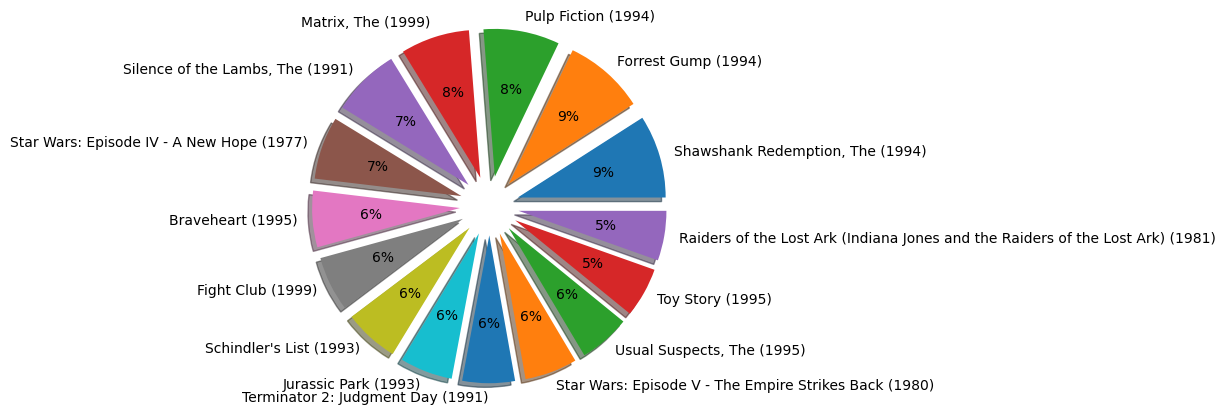

In [22]:
v = viz()
v.viz_pie(non_recom.head(15),'rating',non_recom.head(15).reset_index()['title'],.2)

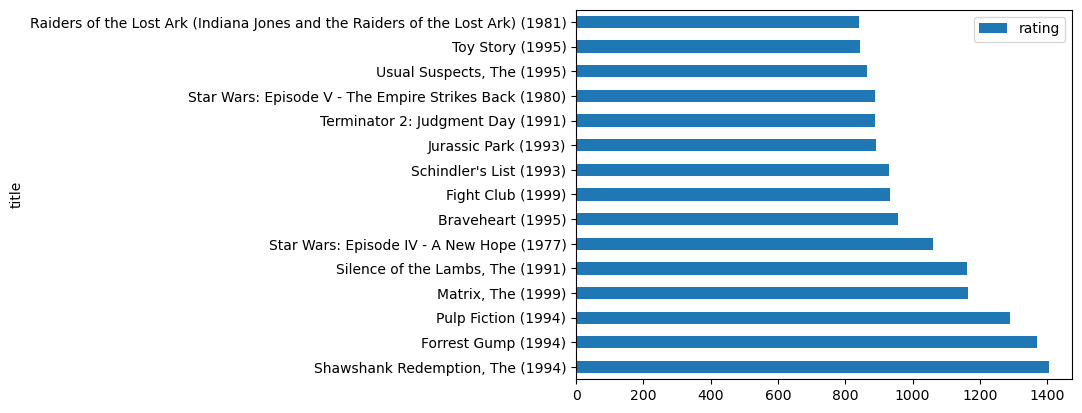

In [23]:
v.viz_bar(non_recom.head(15))

In [59]:
im = interaction_matrix(df,row='userId',columns='title',interaction_value='rating')
im_matrix = im.calculate()


In [60]:
im_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
USR-1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
USR-10,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-100,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-101,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,4.0,0.0,0.0,0.0,0
USR-102,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USR-95,0,0,0.0,0,0,0.0,3.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,2.5,3.0,0.0,0.0,0
USR-96,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
USR-97,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [61]:
## user based collaborative filtering with pearson coeff
active_user_id = 'USR-1'
recom = UserBased_Pearson_coeff(active_user_id,im_matrix)
similar_users = recom.similer_users().sort_values(ascending=False)[1:10]

In [64]:
similer_users_ids = similar_users.index.values

array(['USR-266', 'USR-313', 'USR-368', 'USR-57', 'USR-39', 'USR-452',
       'USR-91', 'USR-469', 'USR-45'], dtype=object)

In [65]:
recom_prod = RecomendActualProduct(active_user_id,similer_users_ids,im_matrix)

In [67]:
top_10_similar_users_watched_movies = recom_prod.recom_product()

In [69]:
## group by similar movie and how much it is watched
## then we recommnd based on the count 
top_10_similar_users_watched_movies_df = pd.DataFrame(top_10_similar_users_watched_movies)
top_10_similar_users_watched_movies_df

,Movie,Rating
0,2001: A Space Odyssey (1968),5.0
1,Aliens (1986),5.0
2,Analyze This (1999),4.0
3,Austin Powers: The Spy Who Shagged Me (1999),5.0
4,Blade (1998),4.0
...,...,...
1193,"Whole Nine Yards, The (2000)",4.0
1194,William Shakespeare's Romeo + Juliet (1996),5.0
1195,"World Is Not Enough, The (1999)",4.0
1196,"X-Files: Fight the Future, The (1998)",4.0


In [77]:
final_recom = top_10_similar_users_watched_movies_df.groupby('Movie')[['Rating']].sum().sort_values(by='Rating',ascending=False).head(10)

In [79]:
final_recom.columns = ['Total Rating']


In [82]:
final_recom

,Total Rating
Movie,
"Godfather, The (1972)",39.0
Aliens (1986),38.0
"Sixth Sense, The (1999)",37.0
"Godfather: Part II, The (1974)",36.0
Terminator 2: Judgment Day (1991),35.0
Die Hard (1988),32.0
"Hunt for Red October, The (1990)",30.5
Blade Runner (1982),30.0
Gattaca (1997),27.5


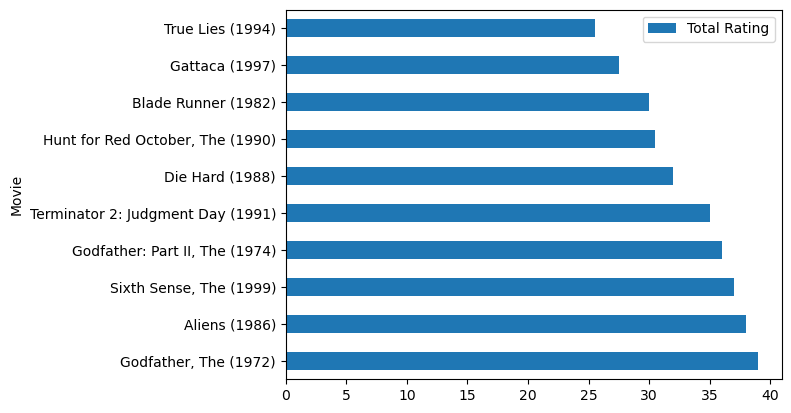

In [85]:
v.viz_bar(final_recom)